# Join 平台眾開講

Things tried so far:

* Simple deep dense model - not going anywhere.  Accuracies usually ~0.4 on validation dataset.

A few things to try next:

* RNN, since the comments tend to be short and paragraph-less.
* CNN
* LRP to explain classifications
* fastText

## Setup

In [1]:
path = "data/join"
topic = "立法方式保障"
# topic = "同性伴侣法"
# topic = "同性婚姻法"

In [33]:
from __future__ import division, print_function
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import jieba
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, BatchNormalization
import os, math

Read in messages from CSV.

In [3]:
def get_messages_from_orig(topic):
    messages = pd.read_csv(os.path.join(path, topic + ".csv"), index_col=0)
    mask = messages.astype('str').applymap(lambda x: len(x.decode('utf-8'))).content > 20
    messages = messages[mask]
    messages.to_csv(os.path.join(path, topic + "-good.csv"))
    return messages

def get_labeled_messages(topic):
    return pd.read_csv(os.path.join(path, topic + "-good.csv"), index_col=0)

def labeled_only(messages):
    return messages[messages.ORID.notnull()]

def unlabeled_only(messages):
    return messages[messages.ORID.isnull()]
    
all_messages = get_messages_from_orig(topic) if not os.path.exists(os.path.join(path, topic + "-good.csv")) \
                                         else get_labeled_messages(topic)
print("Total messages: {count}".format(count=len(all_messages)))
messages = labeled_only(all_messages)
print("Labeled messages: {count}".format(count=len(messages)))
messages.head()

Total messages: 10215
Labeled messages: 277


,createDate,authorName,content,ORID,comments
id,,,,,
14136,2015-08-03 8:57:21,Shaffer Lin,「政府對全體人民的人權有履行義務且不應以公眾之意見作為履行的條件」那現在在投什麼？自打嘴巴？...,R,NaN
14135,2015-08-03 9:30:52,Oliver Lin,贊成歸贊成但更贊成就直接修民法就好了不用疊床架屋我要的沒有比較特別就是現在一堆人在結的那個婚姻,D,NaN
14134,2015-08-03 10:05:26,蛍一 森里,與其以立法的方式來保障不如用修法的方式來保障不是比較方便一些?,I,NaN
14133,2015-08-03 10:08:00,楊剛,投你個花開富貴啦我要不要結婚關順性別異性戀沙豬什麼事啊？啊連個草案都沒有的東西是要投三小喔？...,R,NaN
14132,2015-08-03 10:14:57,黑桐喵,原來別人要不要結婚須要所有人一起投票決定。既然都說了「政府對全體人民的人權有履行義務且不應以...,R,NaN


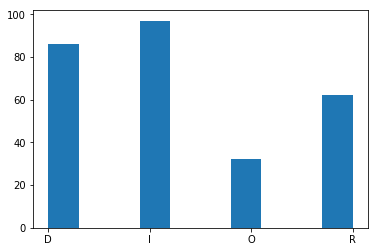

In [4]:
plt.hist(messages.ORID.values)
plt.show()

Build dictionary of phrases and load word embeddings.

In [5]:
def write_dictionary(messages):
    contents = [ jieba.lcut(c) for c in messages.content ]
    all_phrases = set([ ph for c in contents for ph in c ])
    with open(os.path.join(path, "dictionary.txt"), "w") as fh:
        for ph in all_phrases:
            fh.write(ph.encode("utf-8") + "\n")
            
def read_dictionary():
    dictionary = pd.read_csv(os.path.join(path, "dictionary.vec"), 
                       delim_whitespace=True, engine="python", header=None, index_col=0)
    return dictionary

if not os.path.exists("dictionary.vec"):
    write_dictionary(all_messages)
    !cd data/join; ../../../bin/fasttext print-word-vectors models/wiki.zh.bin < dictionary.txt > dictionary.vec
dictionary = read_dictionary()
dictionary.shape

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/sy/q12w5xyn4lngqxh_j63vwr4h0000gn/T/jieba.cache
Loading model cost 0.469 seconds.
Prefix dict has been built succesfully.


(44956, 300)

Build dictionary index to convert phrases into embedding vectors.

In [6]:
dict_index = { ph.decode("utf-8"): i for i, ph in enumerate(dictionary.index) }
dict_index[u"同性"], (dictionary.iloc[dict_index[u"同性"]] == dictionary.loc["同性"]).all()

(35102, True)

Split messages into training and validation datasets.

In [7]:
select = np.random.random(len(messages)) < 0.6
train = messages[select]
valid = messages[~select]

In [8]:
print("Training data: {count}".format(count=len(train)))
train.head()

Training data: 163


,createDate,authorName,content,ORID,comments
id,,,,,
14135,2015-08-03 9:30:52,Oliver Lin,贊成歸贊成但更贊成就直接修民法就好了不用疊床架屋我要的沒有比較特別就是現在一堆人在結的那個婚姻,D,NaN
14132,2015-08-03 10:14:57,黑桐喵,原來別人要不要結婚須要所有人一起投票決定。既然都說了「政府對全體人民的人權有履行義務且不應以...,R,NaN
14131,2015-08-03 10:21:00,Janus Chang,讓更多人可以結婚到底有甚麼問題???? 一堆拿幾千年前教條來干預現代人生活的人真的是社會的敗類。,R,NaN
14130,2015-08-03 13:06:12,Thomas Chen,支持婚姻平權.一步到位.台灣並不以宗教立國.人民有人民的格調.請政府跟上我们的腳步.如果我们...,D,NaN
14129,2015-08-03 15:18:28,Yi Fan Feng,反對特別立法，應該將同性伴侶納入現行民法一體適用，請法務部不要用三個皆為特別法的議程設定來刻...,D,NaN


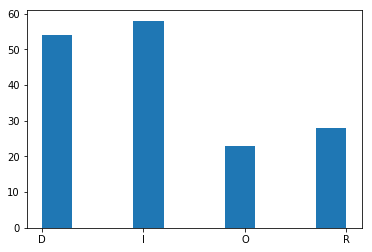

In [9]:
plt.hist(train.ORID.values)
plt.show()

In [10]:
print("Validation data: {count}".format(count=len(valid)))
valid.head()

Validation data: 114


,createDate,authorName,content,ORID,comments
id,,,,,
14136,2015-08-03 8:57:21,Shaffer Lin,「政府對全體人民的人權有履行義務且不應以公眾之意見作為履行的條件」那現在在投什麼？自打嘴巴？...,R,NaN
14134,2015-08-03 10:05:26,蛍一 森里,與其以立法的方式來保障不如用修法的方式來保障不是比較方便一些?,I,NaN
14133,2015-08-03 10:08:00,楊剛,投你個花開富貴啦我要不要結婚關順性別異性戀沙豬什麼事啊？啊連個草案都沒有的東西是要投三小喔？...,R,NaN
14128,2015-08-03 15:35:44,台灣公民,反對同性類婚姻!!!結婚，需要註記，.....因為這不只是私人行為，同時也是公共行為。婚姻定...,D,NaN
14127,2015-08-03 15:42:58,Eugene Lin,照法務部的脈絡是否不同族群都要有各自的一套婚姻制度?!原住民、漢族、異性戀、同性戀、身高超過...,R,NaN


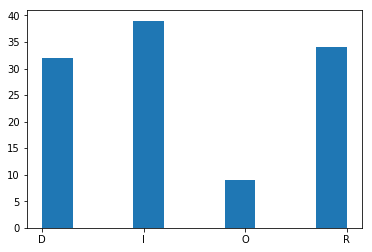

In [11]:
plt.hist(valid.ORID.values)
plt.show()

Setup input length and word embeddings.

In [12]:
input_length = 50

def create_embeddings(dictionary, input_length=100):
    phrases, latents = dictionary.shape
    embedding = Embedding(phrases, latents, input_length=input_length, weights=[dictionary])
    return embedding

In [13]:
def get_data(messages):
    jieba_cut = np.frompyfunc(lambda x: [ ph for ph in jieba.lcut(x.decode("utf-8")) if ph != u" " ][:input_length], 1, 1)
    word_embed = np.frompyfunc(lambda x: [ dict_index[ph] for ph in x ], 1, 1)
    fill_to_length = np.frompyfunc(lambda x: x + [0] * (input_length - len(x)), 1, 1)
    return np.stack(fill_to_length(word_embed(jieba_cut(messages.content.values))), axis=0)

answers_oh = { "O": [1., 0., 0., 0.], "R": [0., 1., 0., 0.], "I": [0., 0., 1., 0.], "D": [0., 0., 0., 1.] }

def orid_to_oh(x): return answers_oh[x]

def get_answer(messages):
    return np.array([ orid_to_oh(x) for x in messages.ORID ])

train = (get_data(train), get_answer(train))
valid = (get_data(valid), get_answer(valid))

In [14]:
train[0][10], train[1][10], valid[0][0], valid[1][0]

(array([ 4250, 36472,  4414, 30777, 20923, 34499,  2970,  8849, 19781,
        36153, 31601, 22711,  4414, 25774, 32998, 24924, 20923, 44600,
         1197, 31858, 19766, 36239, 27709, 22915, 35090, 20923,  7943,
        18552, 31155, 40033, 27537, 19596, 37382, 29821,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]),
 array([ 0.,  0.,  1.,  0.]),
 array([36935, 36621, 21149, 12023, 39845,  4414, 39925, 17642, 18025,
         6176, 18552, 36065, 36659, 11449, 26840, 18025,  4414, 14437,
        11592, 26247, 43183, 43183, 19029, 32546, 13995, 44738, 32546,
        36362, 43962, 27354, 44736, 31155,  5909, 33185, 34499,  4414,
        32548, 29445, 24924, 10395, 37848,  2970,  2757, 27354, 18432,
        29616, 34147, 38528, 27241,  6885]),
 array([ 0.,  1.,  0.,  0.]))

# Single hidden layer model

In [42]:
batch_size = 64

def simple_nn_model():
    model = Sequential()
    model.add(create_embeddings(dictionary, input_length))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation="softmax"))
    return model

simple_nn = simple_nn_model()
simple_nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_7 (Embedding)          (None, 50, 300)       13486800    embedding_input_7[0][0]          
____________________________________________________________________________________________________
flatten_7 (Flatten)              (None, 15000)         0           embedding_7[0][0]                
____________________________________________________________________________________________________
batchnormalization_3 (BatchNorma (None, 15000)         60000       flatten_7[0][0]                  
____________________________________________________________________________________________________
dense_13 (Dense)                 (None, 256)           3840256     batchnormalization_3[0][0]       
___________________________________________________________________________________________

In [43]:
simple_nn.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [44]:
def train_simple_nn(lr=None, epoch=1):
    if lr is not None:
        simple_nn.optimizer.lr = lr
    simple_nn.fit(train[0], train[1], nb_epoch=epoch, validation_data=valid, batch_size=batch_size)


In [45]:
train_simple_nn()
train_simple_nn(lr=1e-1, epoch=2)
train_simple_nn(lr=1e-2, epoch=4)
train_simple_nn(lr=1e-3, epoch=8)
train_simple_nn(lr=1e-4, epoch=8)

Train on 163 samples, validate on 114 samples
Epoch 1/1
163/163 [==============================] - 1s - loss: 2.8947 - acc: 0.2270 - val_loss: 1.7145 - val_acc: 0.3860
Train on 163 samples, validate on 114 samples
Epoch 1/2
163/163 [==============================] - 1s - loss: 2.2769 - acc: 0.5276 - val_loss: 1.5218 - val_acc: 0.3509
Epoch 2/2
163/163 [==============================] - 1s - loss: 1.2323 - acc: 0.7301 - val_loss: 1.3848 - val_acc: 0.3509
Train on 163 samples, validate on 114 samples
Epoch 1/4
163/163 [==============================] - 1s - loss: 0.6904 - acc: 0.8344 - val_loss: 1.3897 - val_acc: 0.3421
Epoch 2/4
163/163 [==============================] - 1s - loss: 0.5221 - acc: 0.8589 - val_loss: 1.6626 - val_acc: 0.3509
Epoch 3/4
163/163 [==============================] - 1s - loss: 0.2923 - acc: 0.9264 - val_loss: 1.6908 - val_acc: 0.3421
Epoch 4/4
163/163 [==============================] - 1s - loss: 0.1881 - acc: 0.9448 - val_loss: 1.8441 - val_acc: 0.2895
Train on

# Evaluation

In [48]:
model = simple_nn

In [50]:
results = unlabeled_only(all_messages).copy()
test_data = get_data(results)
pred = model.predict(test_data, batch_size=batch_size)
orid_fn = np.frompyfunc(lambda x, m: ["O", "R", "I", "D"][x]  if m > 0.4 else "", 2, 1)
pred_orid = orid_fn(np.argmax(pred, axis=1), np.max(pred, axis=1))
results.loc[:, "prediction"] = pd.Series(pred_orid, index=results.index)
results

,createDate,authorName,content,ORID,comments,prediction
id,,,,,,
14138,2015-08-03 8:12:21,小K,那麼亞洲國家的現況呢？以新加坡或日本這兩個已開發的國家來說，是否有進行相關政策？,NaN,NaN,R
14110,2015-08-04 2:41:32,Oliver Lin,你搞錯了，不論性向有錢人是最不受制度限制的一群人如果你擔心這點，請採用共產制度根本上讓大家均貧就好,NaN,NaN,I
14103,2015-08-04 3:43:13,in.j li,"你(妳)知道性取向是天生的,那試問, 如果自然法則是同性交配才能繁殖下一代, 那你(妳)可以...",NaN,NaN,I
14097,2015-08-04 4:29:26,black756133,無神論者無法相信任何沒有存在證據的神說的話，跟神溝通也只能透過古代人編寫的各種版本同人作品自...,NaN,NaN,I
14096,2015-08-04 4:33:21,RED,冰山一角http://news.ltn.com.tw/news/wo...,NaN,NaN,
14088,2015-08-04 5:21:16,RED,網路很多新聞，平時你不看的那種。https://chinesemanif.wordpress...,NaN,NaN,D
14071,2015-08-04 6:40:52,葉佩君,生病血型怨天尤人無醫生醫治。小孩到家庭社會官誰負責。輔導有同性戀傾向與一救醫院協助同性戀我們...,NaN,NaN,I
14067,2015-08-04 6:48:32,Tsuyoshi Kusae,閣下真的好傻好天真，難怪不必講什麼大道理，講了你大概也不會懂。老子我天生愛男人可不是誰去鼓勵...,NaN,NaN,I
14066,2015-08-04 6:49:24,葉佩君,主題有點不清不楚。按讚是不要修改一夫一妻。還是讚成不要同性戀結婚。,NaN,NaN,R


In [51]:
results[results.prediction == "O"]

,createDate,authorName,content,ORID,comments,prediction
id,,,,,,
12902,2015-08-05 4:08:30,方馨香,抗議性教育課程 加安大略學生罷課2015-05-05 09:37:19中央社 中央社記者張若...,NaN,NaN,O
10546,2015-08-11 14:42:32,冰塊,那你結婚也來投一下票好了~~~看看會有多少人贊成你結婚~~又有多少人要反對你結婚~~~因為這...,NaN,NaN,O
9687,2015-08-20 14:04:30,Samuel Chang,同性婚姻通過就等於開啟一道通往一夫多妻、亂倫、人獸交的大門?哲學教授John Corvino...,NaN,NaN,O
9109,2015-09-14 14:04:21,Oliver Lin,"""看看背後收買多少立法會議員，媒體，報紙，刊登同運新聞和欺凌攻擊反對意見就知道。""證據咧?統...",NaN,NaN,O
2861,2015-10-25 14:03:15,Wildy Chan,"你說不是份份報章都可信, 但同運的宣傳也不是全是可信度十足的吧. 你自己GOOGLE一下.多...",NaN,NaN,O


In [52]:
results[results.prediction == "R"]

,createDate,authorName,content,ORID,comments,prediction
id,,,,,,
14138,2015-08-03 8:12:21,小K,那麼亞洲國家的現況呢？以新加坡或日本這兩個已開發的國家來說，是否有進行相關政策？,NaN,NaN,R
14066,2015-08-04 6:49:24,葉佩君,主題有點不清不楚。按讚是不要修改一夫一妻。還是讚成不要同性戀結婚。,NaN,NaN,R
14043,2015-08-04 7:17:38,黃道明,全世界有七十多億人口，你還會擔心人類滅亡？,NaN,NaN,R
14042,2015-08-04 7:17:58,瑪麗亞,"請不要這們說,聖母瑪利亞是童貞女可以產子,違反自然法則成這樣,都有人可以邊兩本書討論成這樣了",NaN,NaN,R
14033,2015-08-04 7:22:59,沒邏輯,"因為,同性婚姻一過,會有一堆人辦婚禮,然後婚紗店老闆與飯店賺太多,老闆們太開心,所以中風了;...",NaN,NaN,R
14026,2015-08-04 7:32:07,黃道明,屁！歐美都通過同性婚姻，也沒發生家庭和社會的絕對敗壞，你有看國際新聞嗎？,NaN,NaN,R
14011,2015-08-04 7:48:33,Oliver Lin,人類有抗生素跟手術可以治病也超不自然環境荷爾蒙也增加不孕的機率你有比較關心環境嗎？,NaN,NaN,R
14009,2015-08-04 7:50:15,Oliver Lin,真的自費之後看誰會崩潰我們就知道究竟有多少人沒穿褲子,NaN,NaN,R
14003,2015-08-04 7:56:05,許詠銓,那你為甚麼可以結婚!!!那也是你的個人權利阿~妳老公外遇也是他的個人權利為甚麼你要生氣既然是...,NaN,NaN,R


In [53]:
results[results.prediction == "I"]

,createDate,authorName,content,ORID,comments,prediction
id,,,,,,
14110,2015-08-04 2:41:32,Oliver Lin,你搞錯了，不論性向有錢人是最不受制度限制的一群人如果你擔心這點，請採用共產制度根本上讓大家均貧就好,NaN,NaN,I
14103,2015-08-04 3:43:13,in.j li,"你(妳)知道性取向是天生的,那試問, 如果自然法則是同性交配才能繁殖下一代, 那你(妳)可以...",NaN,NaN,I
14097,2015-08-04 4:29:26,black756133,無神論者無法相信任何沒有存在證據的神說的話，跟神溝通也只能透過古代人編寫的各種版本同人作品自...,NaN,NaN,I
14071,2015-08-04 6:40:52,葉佩君,生病血型怨天尤人無醫生醫治。小孩到家庭社會官誰負責。輔導有同性戀傾向與一救醫院協助同性戀我們...,NaN,NaN,I
14067,2015-08-04 6:48:32,Tsuyoshi Kusae,閣下真的好傻好天真，難怪不必講什麼大道理，講了你大概也不會懂。老子我天生愛男人可不是誰去鼓勵...,NaN,NaN,I
14061,2015-08-04 6:53:25,Candu Hol,異性戀納粹，歷史會告訴你，有一天你會恨不得把現在的自己砍掉重練，哈哈哈。,NaN,NaN,I
14057,2015-08-04 6:54:40,葉佩君,生病血型要輸入醫生如何處理。要自己負責。處理要三思 而後行。,NaN,NaN,I
14053,2015-08-04 6:59:42,村長,據說異性戀有愛滋的也不少 我有朋友認識很多個 要不他們去給您請安呢？,NaN,NaN,I
14051,2015-08-04 7:01:31,村長,不會因為需要血gay就會幫你生給你 自己留下的孩子自己負責 少牽拖,NaN,NaN,I


In [54]:
results[results.prediction == "D"]

,createDate,authorName,content,ORID,comments,prediction
id,,,,,,
14088,2015-08-04 5:21:16,RED,網路很多新聞，平時你不看的那種。https://chinesemanif.wordpress...,NaN,NaN,D
14055,2015-08-04 6:57:23,葉佩君,後悔還可以。到時候怨天尤人。誰會幫助同性戀人。耶穌基督醫治釋放台灣同性戀人。,NaN,NaN,D
14035,2015-08-04 7:22:15,黃道明,你的邏輯更奇怪，同志是喜歡同性又不是喜歡動物,NaN,NaN,D
14030,2015-08-04 7:29:14,宋天浩,敬愛的主、慈愛的天父，請您原諒葉s亂以主耶穌之名惑亂民眾耳目，祈望主能開啟葉s的智慧。也請主...,NaN,NaN,D
14022,2015-08-04 7:34:28,Pun Lee,不會電腦發表的的再過 20 年就會全部死光光台灣的未來需要靠他們嗎？！,NaN,NaN,D
14006,2015-08-04 7:53:29,Oliver Lin,兩次立法院公聽會盡是些邏輯有洞的人上台這次公開辯論是要誰出來丟臉？,NaN,NaN,D
14004,2015-08-04 7:55:00,青仔,因為當初健保只是政客開出的支票政策也是像樓主說的 健保政策改來改去改到最後醫療體系崩壞沒有...,NaN,NaN,D
13765,2015-08-04 13:05:00,Jon,其實這些東西都無憑無據 只能憑信心 無論是進化論 神創論,NaN,NaN,D
13728,2015-08-04 14:03:08,洪國章,我反對你的反對。１如果真要說大自然倫常的話，大自然生物有８成有同性行為。２異性戀婚姻是合法的...,NaN,NaN,D
